## Reward-effort task simulations

- 400 total trials
    - 40 mins
    - 6s per trial
- 50 total trials per block 
    - 2 action type
    - 2 global effort state 
    - 2 attentional focus
- 34 high conflict trials per block
    - 17 high effort, high reward
    - 17 low effort, low reward
- 16 low conflict trials per block
    - 8 high effort, low reward 
    - 8 low effort, high reward

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # Trial numbers
# num_trials_per_block = 50
# num_blocks = 8
# num_trials = num_trials_per_block * num_blocks

# # Number of high-conflict and low-conflict trials per block
# num_high_conflict = 34
# num_low_conflict = 16

# Reward and effort levels
outcome_levels = np.linspace(-100, 100, 21)  # 21 outcome levels from -100 to 100 (10 reward levels, 10 loss levels)
effort_levels = np.linspace(5, 10, 6)      # 6 effort levels from 5 to 10


In [3]:
# Simulate participants with different sensitivities - get realistic values from the literature
num_participants = 100

# Specify parameters for each participant from unfiorm distributions
# alpha_values = np.random.uniform(0.5, 1.0, num_participants)  # Outcome sensitivity for gains
# beta_values = np.random.uniform(0.5, 1.0, num_participants)   # Outcome sensitivity for losses (could also just have a fixed outcome sensitivity)
# lambda_values = np.random.uniform(1.5, 2.5, num_participants) # Loss aversion coefficient
# k_values = np.random.uniform(0.1, 1.0, num_participants)      # Effort sensitivity
# decision_beta = 1.0                                           # Sensitivity parameter for logistic function


# Perhaps instead of uniform, we should use a normal distribution?
# Specify means and standard deviations 
alpha_mean, alpha_std = 0.8, 0.1
beta_mean, beta_std = 0.8, 0.1
lambda_mean, lambda_std = 2.0, 0.2
k_mean, k_std = 0.35, 0.15
decision_beta = 0.8    
# Generate parameters from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
beta_values = np.random.normal(beta_mean, beta_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)
# Ensure parameters are within a reasonable range
alpha_values = np.clip(alpha_values, 0, 1)
beta_values = np.clip(beta_values, 0, 1)
lambda_values = np.clip(lambda_values, 1, 3)
k_values = np.clip(k_values, 0, 1)

In [4]:
# Function to calculate net value based on outcome, effort, reward sensitivity alpha, loss sensitivty beta, effort sensitivity k, and loss aversion lambda
def calculate_net_value(outcome, effort, alpha, beta, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # positive outcome - effort --> the higher the better
    else:
        return abs(-lambda_ * ((-outcome) ** beta)) - k * (effort ** 2)  # removing the negative sign from the outcome to get magnitude of (negative) outcome - magnitude of effort --> the higher the less bad (ie better)

# Logistic function to get choice probabilities
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))

In [5]:
# Generate stimuli and responses
stimuli = []
responses = []

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, beta, k, lambda_)
                               for alpha, beta, k, lambda_ in zip(alpha_values, beta_values, k_values, lambda_values)])
        
        # Apply logistic function to calculate acceptance probabilities
        probabilities = logistic_choice_prob(net_values, decision_beta)
        
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array
responses = np.array(responses)



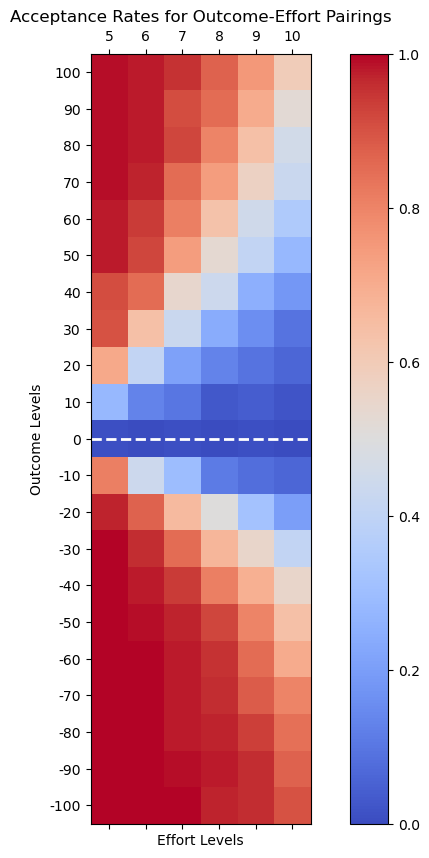

In [6]:
# Visualizing the acceptance rates for each reward-effort pairing across all participants
# Matrix looks asymmetric because of loss aversion
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates for plotting 
# acceptance_rates is a 1D array representing the mean acceptance rates across all participants for each reward-effort pairing
# reshaped acceptance_matrix is a 2D array where rows represent different outcome levels and columns represent different effort levels
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels(effort_levels.astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()

# Adding the horizontal line at the index where outcome = 0
zero_outcome_index = np.where(outcome_levels == 0)[0][0]
ax.axhline(y=zero_outcome_index, color='white', linestyle='--', linewidth=2)

plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
plt.show()


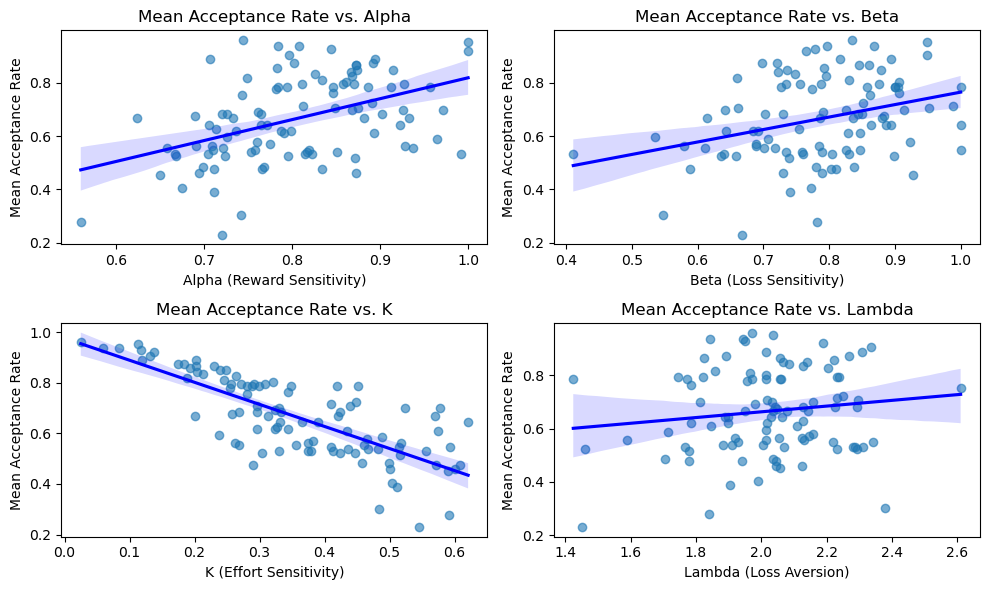

In [7]:
# Visualise how acceptance rates depend on participants' parameters
# Taking mean acceptance rate for each participant

mean_acceptance_rates = responses.mean(axis=0)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

sns.regplot(x=alpha_values, y=mean_acceptance_rates, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 0].set_xlabel('Alpha (Reward Sensitivity)')
axs[0, 0].set_ylabel('Mean Acceptance Rate')
axs[0, 0].set_title('Mean Acceptance Rate vs. Alpha')

sns.regplot(x=beta_values, y=mean_acceptance_rates, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 1].set_xlabel('Beta (Loss Sensitivity)')
axs[0, 1].set_ylabel('Mean Acceptance Rate')
axs[0, 1].set_title('Mean Acceptance Rate vs. Beta')

sns.regplot(x=k_values, y=mean_acceptance_rates, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 0].set_xlabel('K (Effort Sensitivity)')
axs[1, 0].set_ylabel('Mean Acceptance Rate')
axs[1, 0].set_title('Mean Acceptance Rate vs. K')

sns.regplot(x=lambda_values, y=mean_acceptance_rates, ax=axs[1, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 1].set_xlabel('Lambda (Loss Aversion)')
axs[1, 1].set_ylabel('Mean Acceptance Rate')
axs[1, 1].set_title('Mean Acceptance Rate vs. Lambda')

plt.tight_layout()
plt.show()

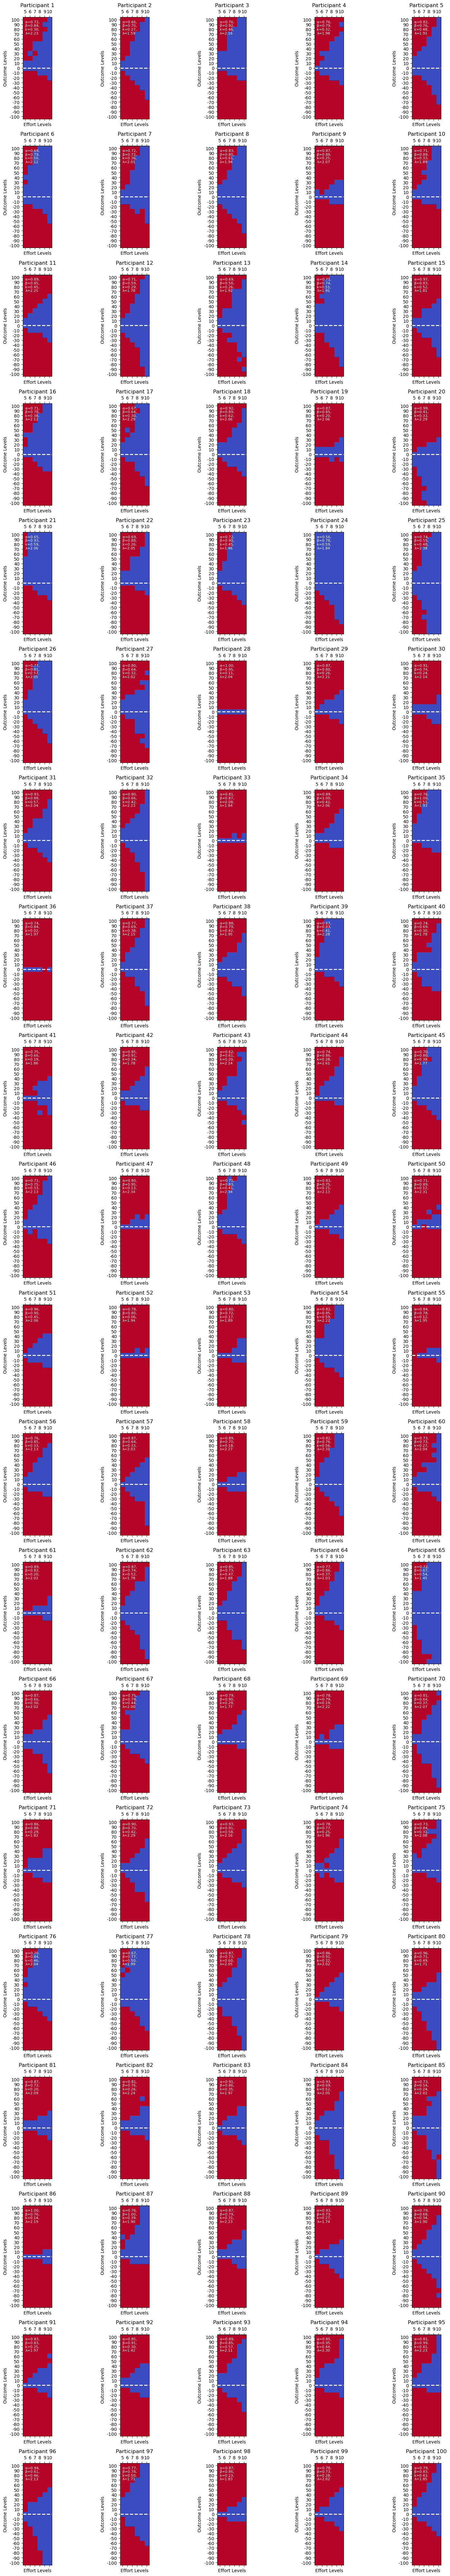

In [8]:
# Visualizing the acceptance rates for each participant separately
num_cols = 5  # Number of plots per row
num_rows = num_participants // num_cols + (1 if num_participants % num_cols else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

for participant_idx in range(num_participants):
    row = participant_idx // num_cols
    col = participant_idx % num_cols
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    participant_responses = responses[:, participant_idx]
    acceptance_matrix = participant_responses.reshape(len(outcome_levels), len(effort_levels))
    
    cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='coolwarm')
    
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels(effort_levels.astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()

    
    # Adding horizontal line
    zero_outcome_index = np.where(outcome_levels == 0)[0][0]
    ax.axhline(y=zero_outcome_index, color='white', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Effort Levels')
    ax.set_ylabel('Outcome Levels')
    ax.set_title(f'Participant {participant_idx + 1}')

    # Print participant parameters 
    params_text = (f"α={alpha_values[participant_idx]:.2f}, \n"
                   f"β={beta_values[participant_idx]:.2f}, \n"
                   f"k={k_values[participant_idx]:.2f}, \n"
                   f"λ={lambda_values[participant_idx]:.2f}")
    ax.text(0, len(outcome_levels) - 4, params_text, color='white', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()